In [3]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

In [6]:
def read_dataset(file_name, sort_key):
    file_path = '../input/' + file_name + '.csv'
    df = pd.read_csv(file_path).sort_values(sort_key).reset_index(drop = True).loc[:1000, :]
    return df

In [7]:
app_train = read_dataset('application_train', 'SK_ID_CURR')
app_test = read_dataset('application_test', 'SK_ID_CURR')
bureau = read_dataset('bureau', 'SK_ID_BUREAU')
bureau_balance = read_dataset('bureau_balance', 'SK_ID_BUREAU')
cash = read_dataset('POS_CASH_balance', ['SK_ID_CURR', 'SK_ID_PREV'])
credit = read_dataset('credit_card_balance', ['SK_ID_CURR', 'SK_ID_PREV'])
previous = read_dataset('previous_application', ['SK_ID_CURR', 'SK_ID_PREV'])
installments = read_dataset('installments_payments', ['SK_ID_CURR', 'SK_ID_PREV'])

In [8]:
app_types = {}

for col in app_train:
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean
        
print('Number of Boolean Variables: ', len(app_types))

Number of Boolean Variables:  33


In [9]:
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

app_test_types = app_types.copy()
del app_test_types['TARGET']

In [10]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}

In [11]:
def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [12]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [13]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-2918 days,-2613 days,-2639 days,-2512 days
1,-1015 days,-831 days,-891 days,-891 days
2,-149 days,-26 days,-26 days,-23 days
3,-135 days,230 days,-42 days,-42 days
4,-47 days,320 days,NaT,-17 days


 These four columns represent different offsets:

* `DAYS_CREDIT`: Number of days before current application at Home Credit client applied for loan at other financial institution. We will call this the application date, `bureau_credit_application_date` and make it the `time_index` of the entity. 
* `DAYS_CREDIT_ENDDATE`: Number of days of credit remaining at time of client's application at Home Credit. We will call this the ending date, `bureau_credit_end_date`
* `DAYS_ENDDATE_FACT`: For closed credits, the number of days before current application at Home Credit that credit at other financial institution ended. We will call this the closing date, `bureau_credit_close_date`. 
* `DAYS_CREDIT_UPDATE`: Number of days before current application at Home Credit that the most recent information about the previous credit arrived. We will call this the update date, `bureau_credit_update_date`. 

If we were doing manual feature engineering, we might want to create new columns such as by subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_CREDIT` to get the `planned length of the loan in days`, or subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_ENDDATE_FACT` to find the `number of days the client paid off the loan early`. However, in this notebook we will not make any features by hand, but rather let featuretools develop useful features for us.

To make date columns from the `timedelta`, we simply add the offset to the start date.

In [14]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

In [15]:
date_cols = ['bureau_credit_application_date', 'bureau_credit_end_date', 
             'bureau_credit_close_date', 'bureau_credit_update_date']

bureau[date_cols].head()

,bureau_credit_application_date,bureau_credit_end_date,bureau_credit_close_date,bureau_credit_update_date
0,2008-01-05,2008-11-05,2008-10-10,2009-02-14
1,2013-03-22,2013-09-22,2013-07-24,2013-07-24
2,2015-08-05,2015-12-06,2015-12-06,2015-12-09
3,2015-08-19,2016-08-18,2015-11-20,2015-11-20
4,2015-11-15,2016-11-16,NaT,2015-12-15


In [16]:
# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

Text(0.5, 1.0, 'Loan Length')

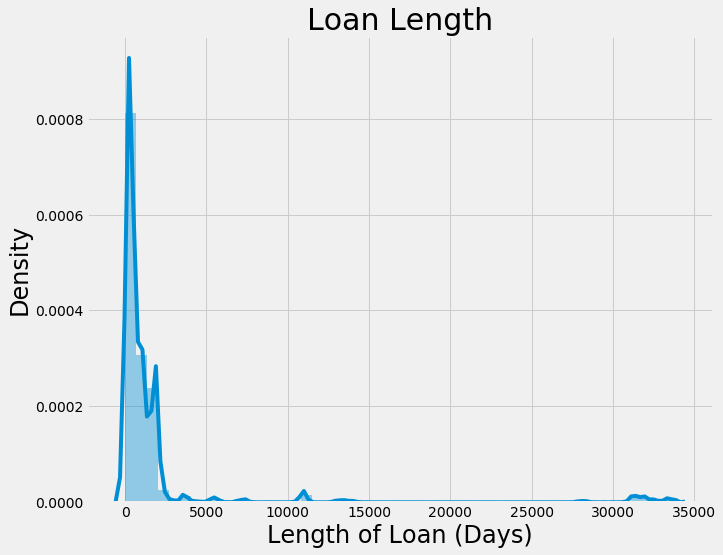

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

days = (bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days

# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

plt.figure(figsize = (10, 8))

sns.distplot(days)

plt.xlabel('Length of Loan (Days)', size = 24) 
plt.ylabel('Density', size = 24) 
plt.title('Loan Length', size = 30)

It looks as if there are a number of loans that are unreasonably long. They could be `outliers` in dataset but for now, leave them as they are.

Text(0, 0.5, 'Status')

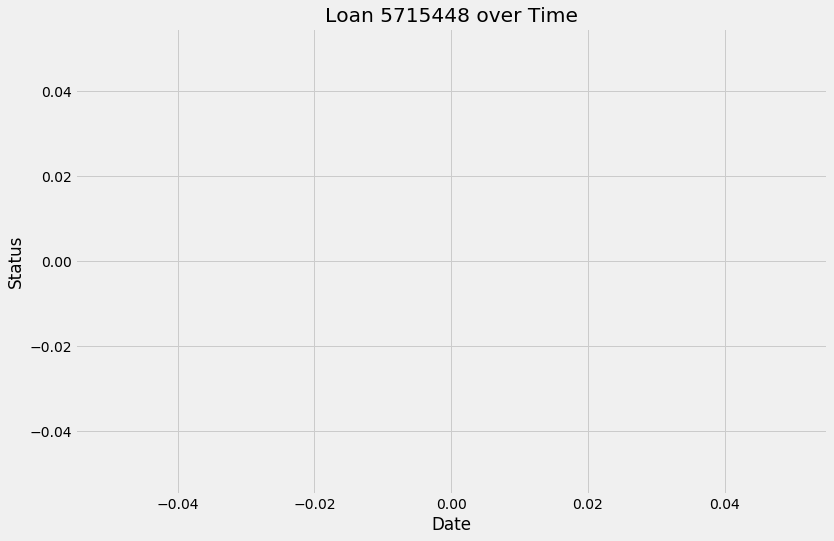

In [18]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'M')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5715448]

plt.figure(figsize = (12, 8))

plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro')

plt.title('Loan 5715448 over Time')
plt.xlabel('Date')
plt.ylabel('Status')

#### Previous Applications

The `previous` dataframe holds previous applications at Home Credit. There are a number of time offset columns in this dataset:

* `DAYS_DECISION`: number of days before current application at Home Credit that decision was made about previous application. This will be the `time_index` of the data.
* `DAYS_FIRST_DRAWING`: number of days before current application at Home Credit that first disbursement was made
* `DAYS_FIRST_DUE`: number of days before current application at Home Credit that first due was suppoed to be
* `DAYS_LAST_DUE_1ST_VERSION`: number of days before current application at Home Credit that first was??
* `DAYS_LAST_DUE`: number of days before current application at Home Credit of last due date of previous application
* `DAYS_TERMINATION`: number of days before current application at Home Credit of expected termination

Let's convert all these into timedeltas in a loop and then make time columns.

Text(0, 0.5, 'Credit Amount')

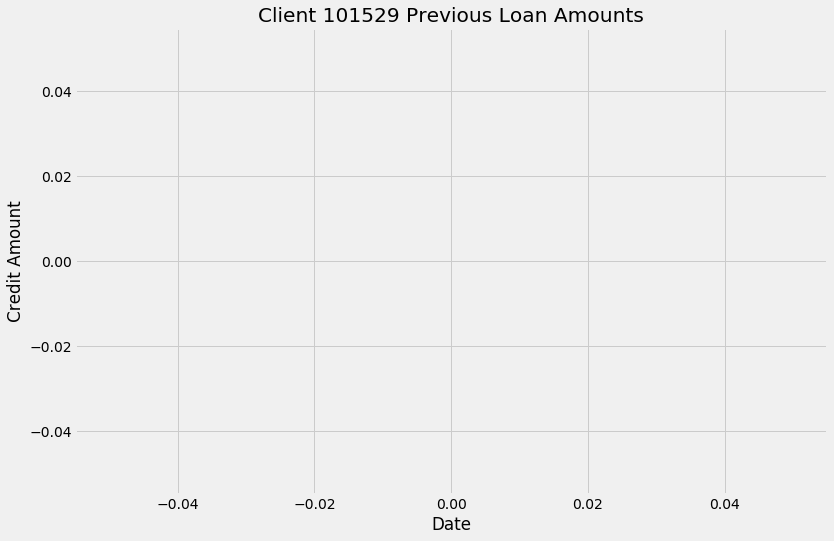

In [19]:
# Convert to timedeltas in days
prev_days_cols = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                  'DAYS_LAST_DUE', 'DAYS_TERMINATION']

for col in prev_days_cols:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = prev_days_cols)

example_client = previous[previous['SK_ID_CURR'] == 101529]

plt.figure(figsize = (12, 8))

plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')

plt.title('Client 101529 Previous Loan Amounts')
plt.xlabel('Date')
plt.ylabel('Credit Amount')

#### Previous Credit and Cash

The `credit_card_balance` and `POS_CASH_balance` each have a `MONTHS_BALANCE` column with the month offset. This is the number of months before the current application at Home Credit of the previous application record. These will represent the `time_index` of the data. 

In [20]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'M')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'M')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

#### Installments Payments 

The `installments_payments` data contains information on each payment made on the previous loans at Home Credit. It has two date offset columns:

* `DAYS_INSTALMENT`: number of days before current application at Home Credit that previous installment was supposed to be paid
* `DAYS_ENTRY_PAYMENT`: number of days before current application at Home Credit that previous installment was actually paid

By now the process should be familiar: convert to timedeltas and then make time columns. The DAYS_INSTALMENT will serve as the `time_index`. 

In [21]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Applying Featuretools

We can now start making features using the time columns. We will create an entityset named clients much as before, but now we have time variables that we can use. 

In [22]:
# Make an entityset
es = ft.EntitySet(id = 'client')

### Entities

When creating the entities, we specify the `index`, the `time_index` (if present), and the `variable_types` (if they need to be specified). 

In [23]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'app_test', dataframe = app_test, 
                              index = 'SK_ID_CURR', variable_types = app_test_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index = 'bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, variable_types = previous_types,
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureau_balance_index', time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index', time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments, 
                              make_index = True, index = 'installments_index', time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit, 
                              make_index = True, index = 'credit_index', time_index = 'credit_balance_date')

### Relationships

The relationships between tables has not changed since the previous implementation. 

In [24]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app_train']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Test Relationship between app and bureau
r_test_app_bureau = ft.Relationship(es['app_test']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app_train']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Test Relationship between current app and previous apps
r_test_app_previous = ft.Relationship(es['app_test']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])

r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])

r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_test_app_bureau, r_bureau_balance, r_app_previous, r_test_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: client
  Entities:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

## Time Features

Let's look at some of the time features we can make from the new time variables. Because these times are relative and not absolute, we are only interested in values that show change over time, such as trend or cumulative sum. We would not want to calculate values like the year or month since we choose an arbitrary starting date. 

We will pass in a `chunk_size` to the `dfs` call which specifies the number of rows (if an integer) or the fraction or rows to use in each chunk (if a float). This can help to optimize the `dfs` procedure, and the `chunk_size` can have a [significant effect on the run time](https://docs.featuretools.com/guides/performance.html). Here we will use a chunk size equal to the number of rows in the data so all the results will be calculated in one pass. We also want to avoid making any features with the testing data, so we pass in `ignore_entities = [app_test]`.

In [25]:
time_features, time_feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                           trans_primitives = ['cum_sum', 'time_since_previous'],
                                           agg_primitives = ['trend'],
                                           features_only = False, verbose = True,
                                           max_depth = 2, chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 340 features
Elapsed: 00:21 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [26]:
pd.options.display.max_columns = 350
time_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,"TREND(previous.CNT_PAYMENT, previous_decision_date)","TREND(previous.SELLERPLACE_AREA, previous_decision_date)","TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date)","TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date)","TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date)","TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date)","TREND(previous.AMT_GOODS_PRICE, previous_decision_date)","TREND(previous.AMT_CREDIT, previous_decision_date)","TREND(previous.AMT_ANNUITY, previous_decision_date)","TREND(previous.AMT_APPLICATION, previous_decision_date)","TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date)","TREND(bureau.AMT_CREDIT_MAX_OVERDUE, bureau_credit_application_date)","TREND(bureau.AMT_CREDIT_SUM_DEBT, bureau_credit_application_date)","TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)","TREND(bureau.CREDIT_DAY_OVERDUE, bureau_credit_application_date)","TREND(bureau.AMT_CREDIT_SUM_OVERDUE, bureau_credit_application_date)","TREND(bureau.AMT_ANNUITY, bureau_credit_application_date)","TREND(bureau.CNT_CREDIT_PROLONG, bureau_credit_application_date)","TREND(bureau.AMT_CREDIT_SUM_LIMIT, bureau_credit_application_date)","TREND(credit.AMT_RECIVABLE, credit_balance_date)","TREND(credit.AMT_PAYMENT_CURRENT, credit_balance_date)","TREND(credit.CNT_DRAWINGS_OTHER_CURRENT, credit_balance_date)","TREND(credit.SK_DPD, credit_balance_date)","TREND(credit.AMT_RECEIVABLE_PRINCIPAL, credit_balance_date)","TREND(credit.AMT_DRAWINGS_OTHER_CURRENT, credit_balance_date)","TREND(credit.AMT_DRAWINGS_ATM_CURRENT, credit_balance_date)","TREND(credit.AMT_DRAWINGS_POS_CURRENT, credit_balance_date)","TREND(credit.SK_DPD_DEF, credit_balance_date)","TREND(credit.AMT_CREDIT_LIMIT_ACTUAL, credit_balance_date)","TREND(credit.AMT_INST_MIN_REGULARITY, credit_

Let's visualize one of these new variables. We can look at the trend in credit size over time. A positive value indicates that the loan size for the client is increasing over time. 

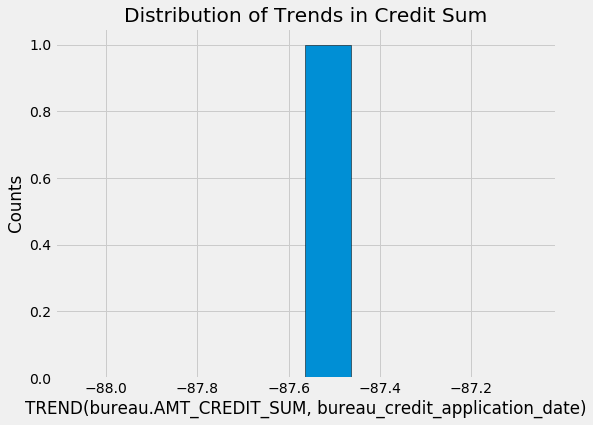

In [27]:
plt.figure(figsize = (8, 6))

plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k')

plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)') 
plt.ylabel('Counts')
plt.title('Distribution of Trends in Credit Sum');

Text(0.5, 1.0, 'Distribution of Trends in Amount of Application')

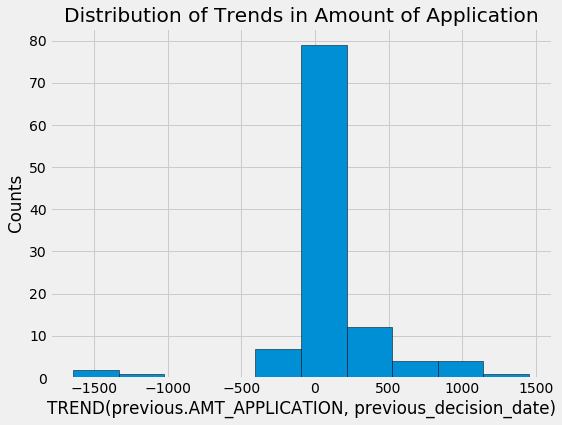

In [28]:
plt.figure(figsize = (8, 6))

plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k')

plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)')
plt.ylabel('Counts')
plt.title('Distribution of Trends in Amount of Application')

# Interesting Values

Another method we can use in featuretools is "interesting values." Specifying interesting values will calculate new features conditioned on values of existing features. For example, we can create new features that are conditioned on the value of `NAME_CONTRACT_STATUS` in the `previous` dataframe. Each stat will be calculated for the specified interesting values which can be useful when we know that there are certain indicators that are of greater importance in the data.  

In [29]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [30]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                                           where_primitives = ['mean', 'mode'],
                                                           trans_primitives = [],
                                                           features_only = False, verbose = True,
                                                           max_depth = 1, chunk_size = len(app_train),
                                                           ignore_entities = ['app_test'])

Built 355 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [31]:
pd.options.display.max_columns = 360
interesting_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,SUM(previous.AMT_ANNUITY),SUM(previous.AMT_APPLICATION),SUM(previous.AMT_CREDIT),SUM(previous.AMT_DOWN_PAYMENT),SUM(previous.AMT_GOODS_PRICE),SUM(previous.HOUR_APPR_PROCESS_START),SUM(previous.RATE_DOWN_PAYMENT),SUM(previous.RATE_INTEREST_PRIMARY),SUM(previous.RATE_INTEREST_PRIVILEGED),SUM(previous.SELLERPLACE_AREA),SUM(previous.CNT_PAYMENT),STD(previous.AMT_ANNUITY),STD(previous.AMT_APPLICATION),STD(previous.AMT_CREDIT),STD(previous.AMT_DOWN_PAYMENT),STD(previous.AMT_GOODS_PRICE),STD(previous.HOUR_APPR_PROCESS_START),STD(previous.RATE_DOWN_PAYMENT),STD(previous.RATE_INTEREST_PRIMARY),STD(previous.RATE_INTEREST_PRIVILEGED),STD(previous.SELLERPLACE_AREA),STD(previous.CNT_PAYMENT),MAX(previous.AMT_ANNUITY),MAX(previous.AMT_APPLICATION),MAX(previous.AMT_CREDIT),MAX(previous.AMT_DOWN_PAYMENT),MAX(previous.AMT_GOODS_PRICE),MAX(previous.HOUR_APPR_PROCESS_START),MAX(previous.RATE_DOWN_PAYMENT),MAX(previous.RATE_INTEREST_PRIMARY),MAX(previous.RATE_INTEREST_PRIVILEGED),MAX(previous.SELLERPLACE_AREA),MAX(previous.CNT_PAYMENT),SKEW(previous.AMT_ANNUITY),SKEW(previous.AMT_APPLICATION),SKEW(previous.AMT_CREDIT),SKEW(previous.AMT_DOWN_PAYMENT),SKEW(previous.AMT_GOODS_PRICE),SKEW(previous.HOUR_APPR_PROCESS_START),SKEW(previous.RATE_DOWN_PAYMENT),SKEW(previous.RATE_INTEREST_PRIMARY),SKEW(previous.RATE_INTEREST_PRIVILEGED),SKEW(previous.SELLERPLACE_AREA),SKEW(previous.CNT_PAYMENT),MIN(previous.AMT_ANNUITY),MIN(previous.AMT_APPLICATION),MIN(previous.AMT_CREDIT),MIN(previous.AMT_DOWN_PAYMENT),MIN(previous.AMT_GOODS_PRICE),MIN(previous.HOUR_APPR_PROCESS_START),MIN(previous.RATE_DOWN_PAYMENT),MIN(previous.RATE_INTEREST_PRIMARY),MIN(previous.RATE_INTEREST_PRIVILEGED),MIN(previous.SELLERPLACE_AREA),MIN(previous.CNT_PAYMENT),MEAN(previous.AMT_ANNUITY),MEAN(previous.AMT_APPLICATION),MEAN(previous.AMT_CR

One of the features is `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)`. This shows the average "term of previous credit" on previous loans conditioned on the previous loan being approved. We can compare the distribution of this feature to the `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)` to see how these loans differ.

Text(0.5, 1.0, 'Average Term of Previous Credit')

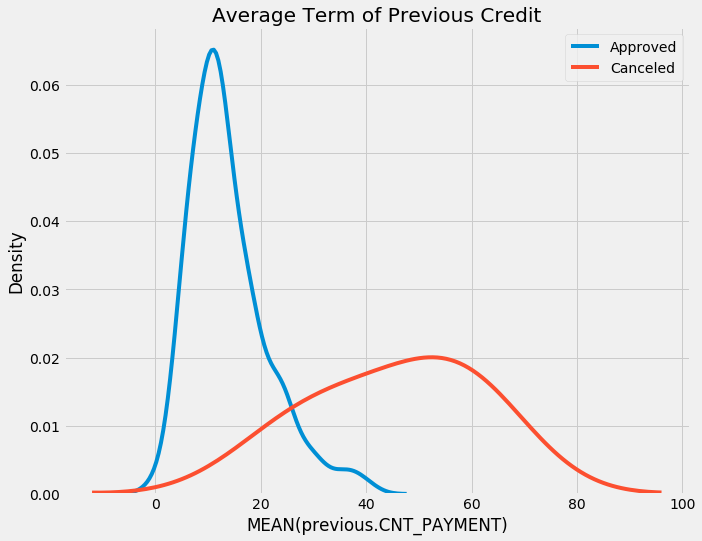

In [32]:
plt.figure(figsize = (10, 8))

sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), 
            label = 'Approved')

sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), 
            label = 'Canceled')

plt.xlabel('MEAN(previous.CNT_PAYMENT)') 
plt.ylabel('Density')
plt.title('Average Term of Previous Credit')

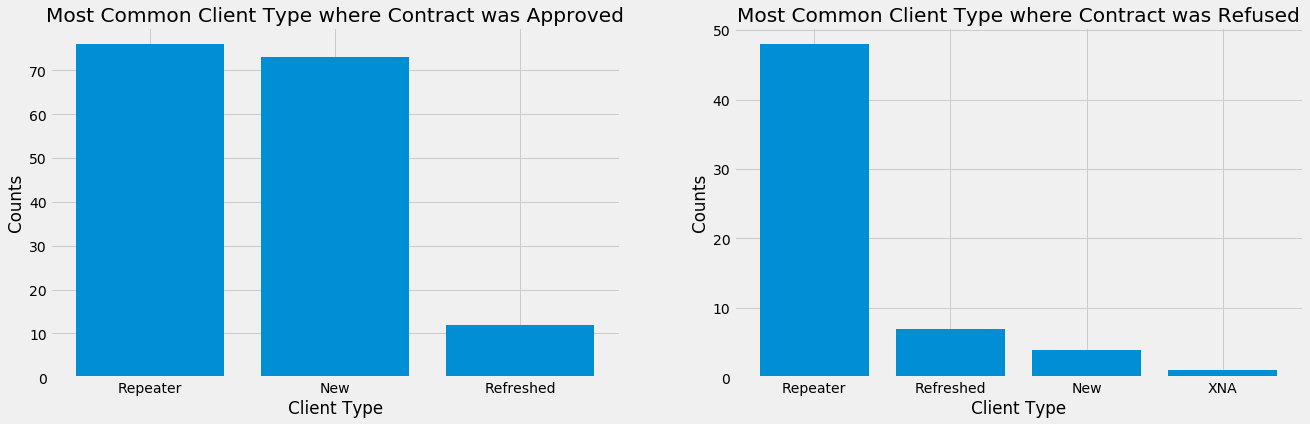

In [33]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)

approved = interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts()

plt.bar(list(range(3)), approved)
plt.xticks(list(range(3)), approved.index)
plt.xlabel("Client Type")
plt.ylabel("Counts")
plt.title("Most Common Client Type where Contract was Approved")

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)

refused = interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts()

plt.bar(list(range(4)), refused)
plt.xticks(list(range(4)), refused.index)
plt.xlabel("Client Type")
plt.ylabel("Counts")
plt.title("Most Common Client Type where Contract was Refused");

In [34]:
# Late Payment seed feature
late_payment = ft.Feature(es['installments']['installments_paid_date']) > ft.Feature(es['installments']['installments_due_date'])

# Rename the feature
late_payment = late_payment.rename('late_payment')

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [],
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 204 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [35]:
pd.options.display.max_columns = 210
seed_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,PERCENT_TRUE(previous.NFLAG_LAST_APPL_IN_DAY),PERCENT_TRUE(previous.NFLAG_INSURED_ON_APPROVAL),MEAN(previous.AMT_ANNUITY),MEAN(previous.AMT_APPLICATION),MEAN(previous.AMT_CREDIT),MEAN(previous.AMT_DOWN_PAYMENT),MEAN(previous.AMT_GOODS_PRICE),MEAN(previous.HOUR_APPR_PROCESS_START),MEAN(previous.RATE_DOWN_PAYMENT),MEAN(previous.RATE_INTEREST_PRIMARY),MEAN(previous.RATE_INTEREST_PRIVILEGED),MEAN(previous.SELLERPLACE_AREA),MEAN(previous.CNT_PAYMENT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.AMT_ANNUITY),MEAN(credit.SK_ID_CURR),MEAN(credit.AMT_BALANCE),MEAN(credit.AMT_CREDIT_LIMIT_ACTUAL),MEAN(credit.AMT_DRAWINGS_ATM_CURRENT),MEAN(credit.AMT_DRAWINGS_CURRENT),MEAN(credit.AMT_DRAWINGS_OTHER_CURRENT),MEAN(credit.AMT_DRAWINGS_POS_CURRENT),MEAN(credit.AMT_INST_MIN_REGULARITY),MEAN(credit.AMT_PAYMENT_CURRENT),MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT),MEAN(credit.AMT_RECEIVABLE_PRINCIPAL),MEAN(credit.AMT_RECIVABLE),MEAN(credit.AMT_TOTAL_RECEIVABLE),MEAN(credit.CNT_DRAWINGS_ATM_CURRENT),MEAN(credit.CNT_DRAWINGS_CURRENT),MEAN(credit.CNT_DRAWINGS_OTHER_CURRENT),MEAN(credit.CNT_DRAWINGS_POS_CURRENT),MEAN(credit.CNT_INSTALMENT_MATURE_CUM),MEAN(credit.SK_DPD),MEAN(credit.SK_DPD_DEF),MEAN(cash.SK_ID_CURR),MEAN(cash.CNT_INSTALMENT),MEAN(cash.CNT_INSTALMENT_FUTURE),MEAN(cash.SK_DPD),MEAN(cash.SK_DPD_DEF),MEAN(installments.SK_ID_CURR),MEAN(installments.NUM_INSTALMENT_VERSION),MEAN(installments.NUM_INSTALMENT_NUMBER),MEAN(installments.AMT_INSTALMENT),MEAN(installments.AMT_PAYMENT),MEAN(previous.MEAN(credit.SK_ID_CURR)),MEAN(previous.MEAN(credit.AMT_BALANCE)),MEAN(previous.MEAN(credit.AMT_CREDIT_LIMIT_ACTUA

Text(0.5, 1.0, 'Late Installment Fraction by Client')

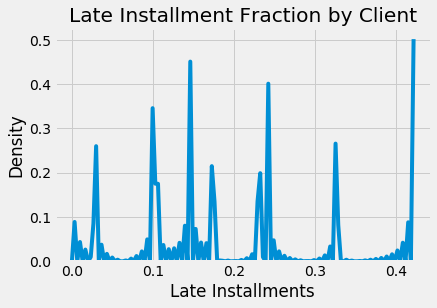

In [36]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')

plt.xlabel('Late Installments')
plt.ylabel('Density')
plt.title('Late Installment Fraction by Client')

Another seed feature we can use is whether or not a previous loan at another institution was past due. 

In [37]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])

# Rename the feature
past_due = past_due.rename('past_due')

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es, 
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [],
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 204 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [38]:
pd.options.display.max_columns = 210
seed_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,PERCENT_TRUE(previous.NFLAG_LAST_APPL_IN_DAY),PERCENT_TRUE(previous.NFLAG_INSURED_ON_APPROVAL),MEAN(previous.AMT_ANNUITY),MEAN(previous.AMT_APPLICATION),MEAN(previous.AMT_CREDIT),MEAN(previous.AMT_DOWN_PAYMENT),MEAN(previous.AMT_GOODS_PRICE),MEAN(previous.HOUR_APPR_PROCESS_START),MEAN(previous.RATE_DOWN_PAYMENT),MEAN(previous.RATE_INTEREST_PRIMARY),MEAN(previous.RATE_INTEREST_PRIVILEGED),MEAN(previous.SELLERPLACE_AREA),MEAN(previous.CNT_PAYMENT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.AMT_ANNUITY),MEAN(credit.SK_ID_CURR),MEAN(credit.AMT_BALANCE),MEAN(credit.AMT_CREDIT_LIMIT_ACTUAL),MEAN(credit.AMT_DRAWINGS_ATM_CURRENT),MEAN(credit.AMT_DRAWINGS_CURRENT),MEAN(credit.AMT_DRAWINGS_OTHER_CURRENT),MEAN(credit.AMT_DRAWINGS_POS_CURRENT),MEAN(credit.AMT_INST_MIN_REGULARITY),MEAN(credit.AMT_PAYMENT_CURRENT),MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT),MEAN(credit.AMT_RECEIVABLE_PRINCIPAL),MEAN(credit.AMT_RECIVABLE),MEAN(credit.AMT_TOTAL_RECEIVABLE),MEAN(credit.CNT_DRAWINGS_ATM_CURRENT),MEAN(credit.CNT_DRAWINGS_CURRENT),MEAN(credit.CNT_DRAWINGS_OTHER_CURRENT),MEAN(credit.CNT_DRAWINGS_POS_CURRENT),MEAN(credit.CNT_INSTALMENT_MATURE_CUM),MEAN(credit.SK_DPD),MEAN(credit.SK_DPD_DEF),MEAN(cash.SK_ID_CURR),MEAN(cash.CNT_INSTALMENT),MEAN(cash.CNT_INSTALMENT_FUTURE),MEAN(cash.SK_DPD),MEAN(cash.SK_DPD_DEF),MEAN(installments.SK_ID_CURR),MEAN(installments.NUM_INSTALMENT_VERSION),MEAN(installments.NUM_INSTALMENT_NUMBER),MEAN(installments.AMT_INSTALMENT),MEAN(installments.AMT_PAYMENT),MEAN(previous.MEAN(credit.SK_ID_CURR)),MEAN(previous.MEAN(credit.AMT_BALANCE)),MEAN(previous.MEAN(credit.AMT_CREDIT_LIMIT_ACTUA

# Create Custom Feature Primitives

If we are not satisfied with the existing primitives in featuretools, we [can write our own](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives). This is an extremely powerful method that lets us expand the capabilities of featuretools. 

### NormalizedModeCount and LongestSeq

As an example, we will make three features, building on code from the [featuretools GitHub](https://github.com/Featuretools/featuretools). These will be aggregation primitives, where the function takes in an array of values and returns a single value.  The first, `NormalizedModeCount`, builds upon the `Mode` function by returning the fraction of total observations in a categorical feature that the model makes up. In other words, for a client with 5 total `bureau_balance` observations where 4 of the `STATUS` were `X`, the value of the `NormalizedModeCount` would be 0.8. The idea is to record not only the most common value, but also the relative frequency of the most common value compared to all observations.  

The second custom feature will record the longest consecutive run of a discrete variable. `LongestSeq` takes in an array of discrete values and returns the element that appears the most consecutive times. Because entities in the entityset are sorted by the `time_index`, this will return the value that occurs the most number of times in a row with respect to time. 





In [39]:
from featuretools.variable_types import (
    Boolean, Datetime,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable,
    Id
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta

from collections import Counter


def normalized_mode_count(x):
    """
    Return the fraction of total observations that 
    are the most common observation. For example, 
    in an array of ['A', 'A', 'A', 'B', 'B'], the 
    function will return 0.6."""
    
    if x.mode().shape[0] == 0:
        return np.nan
            
    # Count occurence of each value
    counts = dict(Counter(x.values))
    # Find the mode
    mode = x.mode().iloc[0]
    # Divide the occurences of mode by the total occurrences
    return counts[mode] / np.sum(list(counts.values()))
    

NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
                                         input_types = [Discrete],
                                         return_type = Numeric)

# Function from https://codereview.stackexchange.com/a/15095
def longest_repetition(x):
    """
    Returns the item with most consecutive occurrences in `x`. 
    If there are multiple items with the same number of conseqcutive occurrences,
    it will return the first one. If `x` is empty, returns None. 
    """
    
    x = x.dropna()
    
    if x.shape[0] < 1:
        return None
    
    # Set the longest element
    longest_element = current_element = None
    longest_repeats = current_repeats = 0
    
    # Iterate through the iterable
    for element in x:
        if current_element == element:
            current_repeats += 1
        else:
            current_element = element
            current_repeats = 1
        if current_repeats > longest_repeats:
            longest_repeats = current_repeats
            longest_element = current_element
            
    return longest_element

LongestSeq = make_agg_primitive(function = longest_repetition,
                                     input_types = [Discrete],
                                     return_type = Discrete)    

In [40]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = [NormalizedModeCount, LongestSeq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])


Built 171 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [41]:
pd.options.display.max_columns = 180
custom_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,NORMALIZED_MODE_COUNT(previous.NAME_CONTRACT_TYPE),NORMALIZED_MODE_COUNT(previous.WEEKDAY_APPR_PROCESS_START),NORMALIZED_MODE_COUNT(previous.FLAG_LAST_APPL_PER_CONTRACT),NORMALIZED_MODE_COUNT(previous.NAME_CASH_LOAN_PURPOSE),NORMALIZED_MODE_COUNT(previous.NAME_CONTRACT_STATUS),NORMALIZED_MODE_COUNT(previous.NAME_PAYMENT_TYPE),NORMALIZED_MODE_COUNT(previous.CODE_REJECT_REASON),NORMALIZED_MODE_COUNT(previous.NAME_TYPE_SUITE),NORMALIZED_MODE_COUNT(previous.NAME_CLIENT_TYPE),NORMALIZED_MODE_COUNT(previous.NAME_GOODS_CATEGORY),NORMALIZED_MODE_COUNT(previous.NAME_PORTFOLIO),NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE),NORMALIZED_MODE_COUNT(previous.CHANNEL_TYPE),NORMALIZED_MODE_COUNT(previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(previous.PRODUCT_COMBINATION),LONGEST_REPETITION(previous.NAME_CONTRACT_TYPE),LONGEST_REPETITION(previous.WEEKDAY_APPR_PROCESS_START),LONGEST_REPETITION(previous.FLAG_LAST_APPL_PER_CONTRACT),LONGEST_REPETITION(previous.NAME_CASH_LOAN_PURPOSE),LONGEST_REPETITION(previous.NAME_CONTRACT_STATUS),LONGEST_REPETITION(previous.NAME_PAYMENT_TYPE),LONGEST_REPETITION(previous.CODE_REJECT_REASON),LONGEST_REPETITION(previous.NAME_TYPE_SUITE),LONGEST_REPETITION(previous.NAME_CLIENT_TYPE),LONGEST_REPETITION(previous.NAME_GOODS_CATEGORY),LONGEST_REPETITION(previous.NAME_PORTFOLIO),LONGEST_REPETITION(previous.NAME_PRODUCT_TYPE),LONGEST_REPETITION(previous.CHANNEL_TYPE),LONGEST_REPETITION(previous.NAME_SELLER_INDUSTRY),LONGEST_REPETITION(previous.NAME_YIELD_GROUP),LONGEST_REPETITION(previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE),NORMALIZED_MODE_COUNT(bureau.CREDIT_CURRENCY),NORMALIZED_MODE_COUNT(bureau.CREDIT_TYPE),LONGEST_REPETITION(bureau.CREDIT_ACTIVE),LONGEST_REPETITION(bureau.CREDIT_CUR

Text(0.5, 1.0, 'Longest Repetition of Previous Name Yield Group')

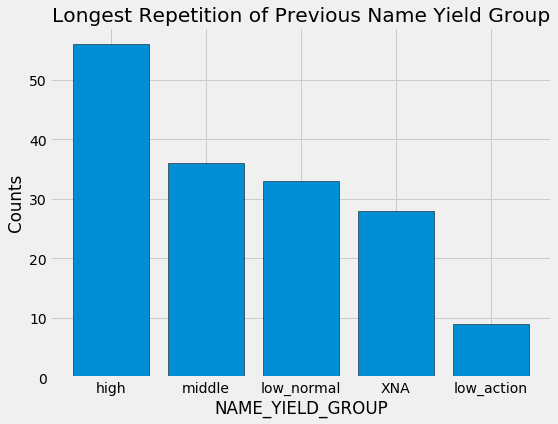

In [42]:
plt.figure(figsize = (8, 6))

repetition = custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts()

plt.bar(repetition.index, repetition, edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP')
plt.ylabel('Counts')
plt.title('Longest Repetition of Previous Name Yield Group')

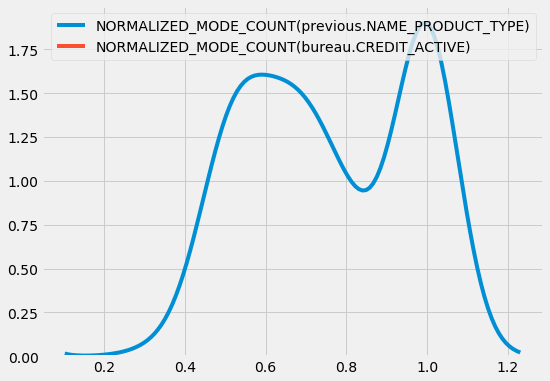

In [43]:
plt.figure(figsize = (8, 6))

sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], 
            label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')

sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], 
            label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

### MostRecent

The final custom feature will be `MOSTRECENT`. This simply returns the most recent value of a discrete variable with respect to time columns in a dataframe. When we create an entity, featuretools will [sort the entity](https://github.com/Featuretools/featuretools/blob/master/featuretools/entityset/entity.py) by the `time_index`. Therefore, the built-in aggregation primitive `LAST` calculates the most recent value based on the time index. However, in cases where there are multiple different time columns, it might be useful to know the most recent value with respect to all of the times. To build the custom feature primitive, I adapted the existing `TREND` primitive ([code here](https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py)). 

In [44]:
# Building on the Trend Aggregation Primitive
# Copied from https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py

def most_recent(y, x):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
            
    if df.shape[0] < 1:
        return np.nan

    # Sort the values by timestamps reversed
    df = df.sort_values('x', ascending = False).reset_index()

    # Return the most recent occurence
    return df.iloc[0]['y']

MostRecent = make_agg_primitive(function = most_recent,
                                input_types = [Discrete, Datetime],
                                return_type = Discrete)

In [45]:
# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = ['last', MostRecent],
                                               max_depth = 1,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])

Built 269 features
Elapsed: 00:44 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [46]:
pd.options.display.max_columns = 270
custom_features.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,LAST(previous.NAME_CONTRACT_TYPE),LAST(previous.AMT_ANNUITY),LAST(previous.AMT_APPLICATION),LAST(previous.AMT_CREDIT),LAST(previous.AMT_DOWN_PAYMENT),LAST(previous.AMT_GOODS_PRICE),LAST(previous.WEEKDAY_APPR_PROCESS_START),LAST(previous.HOUR_APPR_PROCESS_START),LAST(previous.FLAG_LAST_APPL_PER_CONTRACT),LAST(previous.RATE_DOWN_PAYMENT),LAST(previous.RATE_INTEREST_PRIMARY),LAST(previous.RATE_INTEREST_PRIVILEGED),LAST(previous.NAME_CASH_LOAN_PURPOSE),LAST(previous.NAME_CONTRACT_STATUS),LAST(previous.NAME_PAYMENT_TYPE),LAST(previous.CODE_REJECT_REASON),LAST(previous.NAME_TYPE_SUITE),LAST(previous.NAME_CLIENT_TYPE),LAST(previous.NAME_GOODS_CATEGORY),LAST(previous.NAME_PORTFOLIO),LAST(previous.NAME_PRODUCT_TYPE),LAST(previous.CHANNEL_TYPE),LAST(previous.SELLERPLACE_AREA),LAST(previous.NAME_SELLER_INDUSTRY),LAST(previous.CNT_PAYMENT),LAST(previous.NAME_YIELD_GROUP),LAST(previous.PRODUCT_COMBINATION),LAST(previous.NFLAG_LAST_APPL_IN_DAY),LAST(previous.NFLAG_INSURED_ON_APPROVAL),"MOST_RECENT(previous.PRODUCT_COMBINATION, previous_drawing_date)","MOST_RECENT(previous.NAME_GOODS_CATEGORY, previous_first_due_date)","MOST_RECENT(previous.NAME_CONTRACT_TYPE, previous_first_due_date)","MOST_RECENT(previous.NAME_CONTRACT_TYPE, previous_last_duefirst_date)","MOST_RECENT(previous.WEEKDAY_APPR_PROCESS_START, previous_last_due_date)","MOST_RECENT(previous.FLAG_LAST_APPL_PER_CONTRACT, previous_last_due_date)","MOST_RECENT(previous.NAME_CLIENT_TYPE, previous_last_due_date)","MOST_RECENT(previous.PRODUCT_COMBINATION, previous_last_duefirst_date)","MOST_RECENT(previous.NAME_GOODS_CATEGORY, previous_decision_date)","MOST_RECENT(previous.CHANNEL_TYPE, previous_last_duefirst_date)","MOST_RECENT(previous.NAME_CONTRACT_STATUS, previous_first_due_date)","MOST_RECENT(previous.NAME_GOODS_CATEGORY, previous_te

# Putting it all Together

Finally, we can run deep feature synthesis with the time variables, with the correct specified categorical variables, with the interesting features, with the seed features, and with the custom features. To actually run this on the entire dataset, we can take the code here, put it in a script, and then use more computational resources. 

In [47]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_entities = ['app_test'])

Built 4127 features
Elapsed: 02:22 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


We will now do the same operation applied to the test set. Doing the calculations separately should prevent leakage from the testing data into the training data.

In [48]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(entityset = es, target_entity = 'app_test',
                                                   agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                                     'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                                   trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                                   where_primitives = ['mean', 'sum'],
                                                   seed_features = [late_payment, past_due],
                                                   max_depth = 2, features_only = False, verbose = True,
                                                   chunk_size = len(app_test),
                                                   ignore_entities = ['app_train'])

Built 4126 features
Elapsed: 00:30 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


## Remove Features

[Feature selection](https://en.wikipedia.org/wiki/Feature_selection) is an entire topic to itself. However, one thing we can do is use the built-in featuretools [selection function to remove](https://docs.featuretools.com/generated/featuretools.selection.remove_low_information_features.html) columns that only have one unique value or have all null values. 

In [49]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 828 features from training features
Removed 1139 features from testing features


When we're done, we probably want to save the results to a csv. We want to be careful because the index of the dataframe is the identifying column, so we should keep the index. We also should align the training and testing dataframes to make sure they have the same columns.

In [50]:
train_labels = feature_matrix['TARGET']
feature_matrix, feature_matrix_test = feature_matrix2.align(feature_matrix_test2, join = 'inner', axis = 1)
feature_matrix['TARGET'] = train_labels

print('Final training shape: ', feature_matrix.shape)
print('Final testing shape: ', feature_matrix_test.shape)

Final training shape:  (1001, 2988)
Final testing shape:  (1001, 2987)


In [ ]:
# Save the feature matrix to a csv
feature_matrix.to_csv('E:/Kaggle/home-credit-default-risk/datasets/feature_matrix.csv')
feature_matrix_test.to_csv('E:/Kaggle/home-credit-default-risk/datasets/feature_matrix_test.csv')

# Conclusions 

In this notebook we explored some of the advanced functionality in featuretools including:

* Time Variables: allow us to track trends over time 
* Interesting Variables: condition new features on values of existing features
* Seed Features: define new features manually that featuretools will then build on top of
* Custom feature primitives: design any transformation or aggregation feature that can incorporate domain knowledge